## [II] GENERAL EQUILIBRIUM

For the general equlinrium case we assumed Cobb-Douglas production function, fixing labor at 1, and labor share ($\alpha$) is 0.67, and we used VFI method to calculate GE.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
plt.style.use("ggplot")

In [1]:
class HW5_VFI_GE:
    
    def __init__(self, rho, r, sigma, c_bar, gamma, sigma_y, y):
        self.rho = rho
        self.r = r
        self.sigma = sigma
        self.c_bar = c_bar
        self.gamma = gamma
        self.sigma_y = sigma_y
        self.beta = 1/(1+rho)
        self.Y1 = [y-sigma_y, y+sigma_y]
        self.PI1 = [[(1+gamma)/2, (1-gamma)/2], [(1-gamma)/2, (1+gamma)/2]]
        self.A_min = round(-min(self.Y1)*((1+r)/r)/1.3) #divide by 1.3 temporarily
        #self.A = np.linspace(self.A_min, 100, 100)       
        self.p = int(abs(self.A_min)+20+1)
        self.A = np.linspace(self.A_min, 20, self.p)
            
    def u(self, c):
        if c<0:
            return(-1111111111)
        else:
            if self.sigma > 0:
                return ((c**(1-self.sigma)-1)/(1-self.sigma)) #CRRA
            else:
                return (-0.5*(c-self.c_bar)**2) #quad
        

    def d_u(self, c):
        if c<0:
            return(-33333333)
        else:   
            if self.sigma > 0:
                return (c**(-self.sigma))
            else:
                return (-(c-self.c_bar))
    
    #Coob Douglas prod. function. Labor fixed as 1. Alpha = 0.67        
    def F(K):
        return(K**(1-0.67)*1**(0.67))
        
    #derivative of F wrt capital.
    #function of "r" wrt "L"
    #demand for capital
    def d_F_K(K):
        return((1-0.67)*K**(-0.67))
    
    #derivative of F wrt Labor.
    def d_F_L(K):
        return((0.67)*K**(1-0.67)*1*(0.67-1))
     
    
    def m(self, ai,aj, y):
        if aj<self.A_min:
            return -9999999999999999999
        else:
            c = y-aj+ai*(1+self.r)
            #Step 4 (consumption must be non negative)
            if c >= 0:
                return self.u(c)
            else:
                return (-10000000000000000000)

    def matrix_M(self):
        M = [0]*(self.p*len(self.Y1))
        for i in range(self.p*len(self.Y1)):
            M[i] = [0] * self.p
        for prod in range(len(self.Y1)):
            for i in range(self.p):
                for j in range(self.p):
                    index = i+self.p*prod
                    M[index][j] = self.m(self.A[i], self.A[j], self.Y1[prod])
        return(M)            

    def matrix_W(self, V):
        #Step 5.0: Compute the matrix Wsq×p,
        W = [0]*len(self.Y1)
        for i in range(len(self.Y1)):
            W[i] = [0] * self.p
    
        for j in range(self.p):
            for i in range(len(self.Y1)):
                W[i][j] = 0
                for x in range(len(self.Y1)):
                    W[i][j] = W[i][j] + self.PI1[i][x]*V[-1][j] #to do 
        
        return(W)
    
    def CHI(self, M, W):
        Chi = [0]*(self.p*len(self.Y1))  
        for i in range(self.p*len(self.Y1)):
            Chi[i] = [0] * self.p
                
        for j in range(self.p):
            for i in range(self.p*len(self.Y1)):
                Chi[i][j] = 0
                for x in range(len(self.Y1)):
                    Chi[i][j] = M[i][j] + self.beta*W[x][j]   
                
        return(Chi)    
    
    def consum_path(self, assets_path, y):
        Consum_path = []
        for i in range(len(assets_path)-1):
            Consum_path.append(y+(1+self.r)*assets_path[i]-assets_path[i+1])
        return(Consum_path)

    def update_V(self, V, Chi, a_dec):
        V_new = [0]*(self.p*len(self.Y1))
        a_dec_new = [0]*(self.p*len(self.Y1))
        for i in range(self.p*len(self.Y1)):
            V_new[i]=max(Chi[i])
            a_dec_new[i] = np.argmax(Chi[i])
            
        V.append(V_new)
        a_dec.append(a_dec_new)
    
        return(V, a_dec)
        
    def main_VFI(self):
        #Step 4
        V = []
        a_dec = []
        V.append(list(np.zeros(int(self.p*len(self.Y1))))) #Guess a solution
        V.append(list(np.zeros(int(self.p*len(self.Y1)))))
        a_dec.append(list(np.zeros(self.p*len(self.Y1))))
        a_dec.append(list(np.zeros(self.p*len(self.Y1))))
    
        M = self.matrix_M()
        W = self.matrix_W(V) #Step 5.0
        Chi = self.CHI(M, W) #Step 5.1
        V, a_dec = self.update_V(V, Chi, a_dec) #STEP 5.2
           
        while (np.linalg.norm(np.asarray(V[-1]) - np.asarray(V[-2])) > 1): #STEP 6: If ||Vs+1 − Vs|| < ε, stop and report success. Otherwise, go back to the previous step, STEP 5, replacing s = s + 1.
            W = self.matrix_W(V) #Step 5.0
            Chi = self.CHI(M, W) #Step 5.1
            V, a_dec = self.update_V(V, Chi, a_dec) #STEP 5.2
            
        return(V, a_dec)
    
    def recover_C(self):
        V, a_dec = self.main_VFI()
        c_dec = [0]*len(self.Y1)
        a_dec_temp = [0]*len(self.Y1)
        for i in range(len(self.Y1)):
            c_dec[i]=[0]*len(self.A)
            a_dec_temp[i]=[0]*len(self.A)
            
        for y in range(len(self.Y1)):
            for a in range(len(self.A)):
                idx=int(a+y*len(self.A))
                c_dec[y][a] = self.Y1[y] + (1+self.r)*self.A[a] - self.A[a_dec[-1][idx]]
                a_dec_temp[y][a] = self.A[a_dec[-1][idx]] #transform a_dec variable:
        
        return(c_dec, a_dec_temp)
    
    def ass_SS(self):
        assets_path = self.recover_C()[1]
        for i in range(len(assets_path[0])):
            if assets_path[0][i] == self.A[i]:
                Ass_SS = assets_path[0][i]
        return(Ass_SS)

We assume that there is a reprsentative agent and respentative firm. Supply of the capital is given by the level of assets of the agent in the steady-state. Interest rate function has concave shape. Suuply of capital is increasing with the interest rate.

No handles with labels found to put in legend.


Text(0,0.5,'Interest rate')

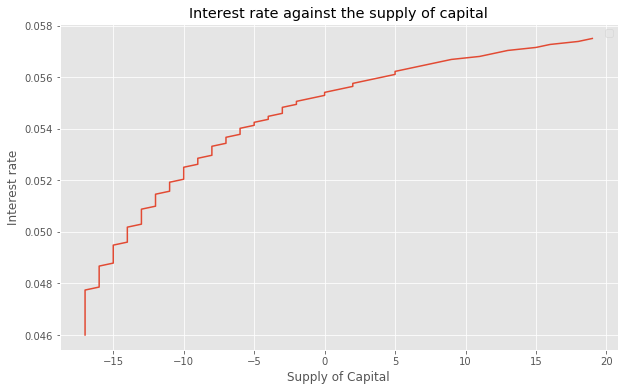

In [6]:
#ass SS
TEST = HW5_VFI_GE(0.06, 0.0555, 0.2, 100, 0, 0, 1)
TEST.ass_SS()
#plot supply of capital
r_space = np.linspace(0.046, 0.0575, 100)
supply = [0]*len(r_space)
for i in range(len(r_space)):
    TEMP = HW5_VFI_GE(0.06, r_space[i], 0.2, 100, 0, 0, 1)
    supply[i] = TEMP.ass_SS()
plt.plot(supply, r_space)
plt.title('Interest rate against the supply of capital')
plt.legend()
plt.rcParams["figure.figsize"] = (10,6)
plt.xlabel('Supply of Capital')
plt.ylabel('Interest rate')

With increase of interest rate the demand of capital is decreasing.

C:\Users\adamw\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'Interest rate')

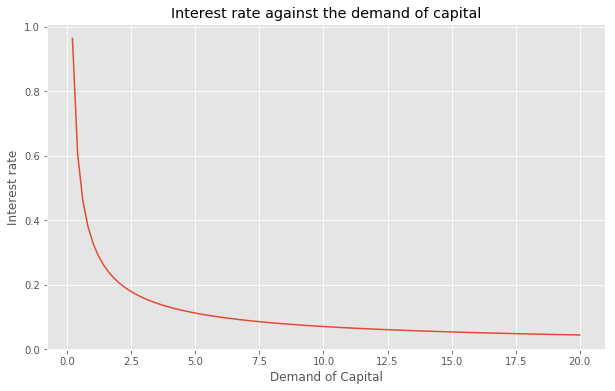

In [7]:
#plot demand of capital
K = np.linspace(0, 20, 100)
plt.plot(K, (1-0.67)*K**(-0.67))
plt.title('Interest rate against the demand of capital')
plt.rcParams["figure.figsize"] = (10,6)
plt.xlabel('Demand of Capital')
plt.ylabel('Interest rate')

###### Calculating the GE we draw aggregate supply and demand curves, and the intersection gives equilibrium interest rates and capital.

C:\Users\adamw\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


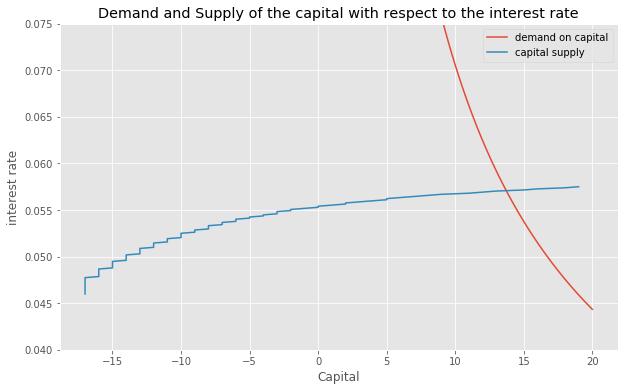

In [8]:
#plot demand and supply
def plot_demand_supply():
    plt.plot(K, (1-0.67)*K**(-0.67), label='demand on capital')
    plt.plot(supply, r_space, label = 'capital supply')
    plt.ylim([0.04,0.075])
    plt.legend()
    plt.ylabel('interest rate')
    plt.xlabel('Capital')   
    plt.title('Demand and Supply of the capital with respect to the interest rate')
plot_demand_supply()

C:\Users\adamw\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


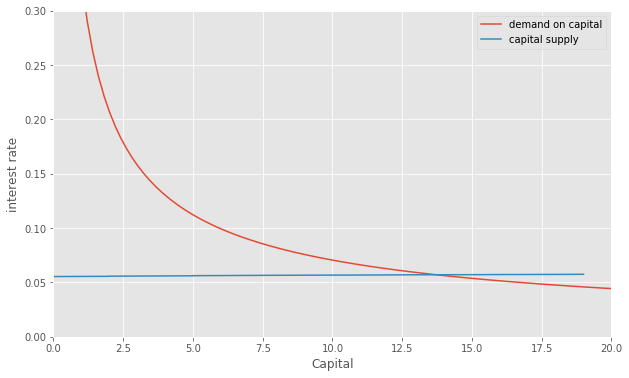

In [9]:
#plot demand and supply (different scale)
def plot_demand_supply2():
    plt.plot(K, (1-0.67)*K**(-0.67), label='demand on capital')
    plt.plot(supply, r_space, label = 'capital supply')
    plt.xlim([0,20])
    plt.ylim([0,0.3])
    plt.legend()
    plt.ylabel('interest rate')
    plt.xlabel('Capital')
plot_demand_supply2()